# overview of campaign deployments: taos0-drifters0 + taos0-drifters1

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import pynsitu as pin

In [2]:
# load all
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/"
cp0 = pin.Campaign(os.path.join(root_dir,f"drifters0/taos0_drifters0.yaml"))
cp1 = pin.Campaign(os.path.join(root_dir,f"drifters1/taos0_drifters1.yaml"))
C = dict(taos0_drifters0=cp0, taos0_drifters1=cp1)

# plot all deployments
for c, cp in C.items():

    print(f"-----  {c} ")
    for label, deployment, platform, sensor, meta in cp.get_all_deployments():
        print(platform, sensor, deployment)

-----  taos0_drifters0 
drifter0 None d0 / start 2022-05-11 05:10:00 -0.24 49.34 / end 2022-05-13 07:10:00 -0.01 49.36
drifter1 None d0 / start 2022-05-11 05:40:00 -0.25 49.33 / end 2022-05-13 07:20:00 -0.04 49.35
drifter2 None d0 / start 2022-05-11 05:50:00 -0.24 49.34 / end 2022-05-13 07:30:00 -0.04 49.35
drifter3 None d0 / start 2022-05-11 05:50:00 -0.24 49.34 / end 2022-05-13 07:30:00 -0.04 49.35
drifter4 None d0 / start 2022-05-11 05:50:00 -0.25 49.34 / end 2022-05-11 08:40:00 -0.25 49.34
drifter4 None d1 / start 2022-05-11 09:20:00 -0.27 49.34 / end 2022-05-13 07:30:00 -0.04 49.35
drifter5 None d0 / start 2022-05-11 06:00:00 -0.24 49.35 / end 2022-05-11 06:20:00 -0.23 49.35
drifter5 None d1 / start 2022-05-11 06:40:00 -0.23 49.35 / end 2022-05-13 08:00:00 -0.04 49.35
parceque None d0 / start 2022-05-11 04:26:00 / end 2022-05-11 07:15:00
parceque None d1 / start 2022-05-13 05:26:00 / end 2022-05-13 09:20:00
parceque ctd u0 / start 2022-05-11 05:39:00 -0.22 49.36 / end 2022-05-11 0

In [3]:
root_dir_other = "/Users/aponte/Current_Projects/taos/campagnes/other/"
cpo = pin.Campaign(os.path.join(root_dir_other, "taos_other.yaml"))

dst = cpo.load("tide_gauge_ouistreham.nc",  toframe=True)

In [4]:
D, S, W, Slvl = (dict() for _ in range(4))

def load_platform_deployments(p):
    return pd.concat([cp.load(f'{p}_{d}.nc', toframe=True) for d in cp[p].deployments()])


for c, cp in C.items():

    D[c] = cp.load('drifters.nc', toframe=True)

    #S[c] = dict(ship_hydrophone=load_platform_deployments('hydrophone'),
    #            ship_parceque=load_platform_deployments('parceque'),
    #           )
    
    W[c] = cp.load("arome.nc")
    #Slvl[c] = cp.load('sea_level.nc', toframe=True)
    Slvl[c] = dst

--- 
### Plot overview of both campaigns along with sea level and wind

In [22]:
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

def plot_combined_deployments(wind_stress=True, quiver_scale=None):

    fig, axes = plt.subplots(3,1, figsize=(10,7))

    height=10
    y=0
    starts, ends = [], []

    ax = axes[0]

    for c, cp in C.items():

        start = mdates.date2num(cp["start"])
        end = mdates.date2num(cp["end"])
        rect = Rectangle((start, y-height/2.), end-start, height,
                         color="orange")
        ax.add_patch(rect)
        starts.append(start)
        ends.append(end)
        #print(start, end-start)
        ax.text(start, y+height*0.4, c)

    # sea level
    _mtime = Slvl[c].index.map(lambda t: mdates.date2num(t))
    #_slvl = Slvl[c].sea_level.values
    #ax.plot(_mtime, _slvl, color="k", label="sea level")
    _slvl = Slvl[c].sea_level_tide.values
    ax.plot(_mtime, _slvl, color="k", label="tidal sea level")

    delta_time = max(ends) - min(starts)

    def _set_axis(ax, xticklabels=True):

        ax.set_xlim(min(starts)-0.1*delta_time, max(ends)+0.1*delta_time)
        locator = mdates.AutoDateLocator(minticks=3)
        #formatter = mdates.AutoDateFormatter(locator)
        formatter = mdates.DateFormatter("%m-%d")
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        if not xticklabels:
            ax.set_xticklabels([])
        ax.grid()

    _set_axis(ax, xticklabels=False)
    ax.legend(loc='lower center')
    ax.set_ylabel("[m]")
    ax.set_ylim(-5,5)

    ### wind sticks
    ax = axes[1]

    # wind data
    #for w in W:
    w = W[list(W)[1]]
    _mtime = mdates.date2num(w.time)
    lon, lat = cp["drifter0"]["d0"].start.lon, cp["drifter0"]["d0"].start.lat
    _w = w.sel(longitude=lon, latitude=lat, method="nearest")
    _w_sub = _w.isel(time=slice(0,None,2))

    if wind_stress:
        scale = -3600 # s
        q = ax.quiver(_w_sub.time, _w_sub.ustress*0, 
                      _w_sub.ustress/scale, _w_sub.vstress/scale,
                      scale=quiver_scale,
                     )
        qk = ax.quiverkey(q, 0.8, 0.8, .2, r'$0.1\;Pa/m^2$', labelpos='E',
                           coordinates='axes')
    else:
        q = ax.quiver(_w_sub.time, _w_sub.u10m*0, 
                      _w_sub.u10m, _w_sub.v10m,
                      scale=quiver_scale,
                     )
        qk = ax.quiverkey(q, 0.8, 0.8, 10., r'$10\;m/s$', labelpos='E',
                           coordinates='axes')
    _set_axis(ax, xticklabels=False)
    
    ### wind strength
    ax = axes[2]
    
    if wind_stress:
        # wind stress
        _uvstress = np.sqrt(_w.ustress**2+_w.vstress**2)
        ax.plot(_mtime, _uvstress/scale, color="k", label="wind stress")
        ax.plot(_mtime, _w.ustress/scale, label="u stress")
        ax.plot(_mtime, _w.vstress/scale, label="v stress")
        ax.set_ylabel("[Pa]")
    else:
        # wind speed
        _uv10 = np.sqrt(_w.u10m**2+_w.v10m**2)
        ax.plot(_mtime, _uv10, color="k", label="wind speed")
        ax.plot(_mtime, _w.u10m, label="u")
        ax.plot(_mtime, _w.v10m, label="v")
        ax.set_ylabel("[m/s]")

    _set_axis(ax)
    ax.legend()


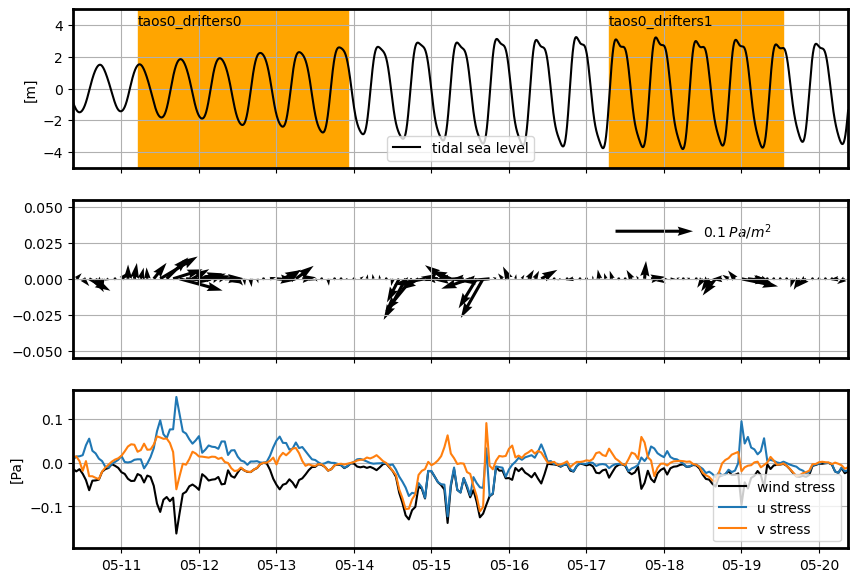

In [25]:
plot_combined_deployments(wind_stress=True, quiver_scale=2)

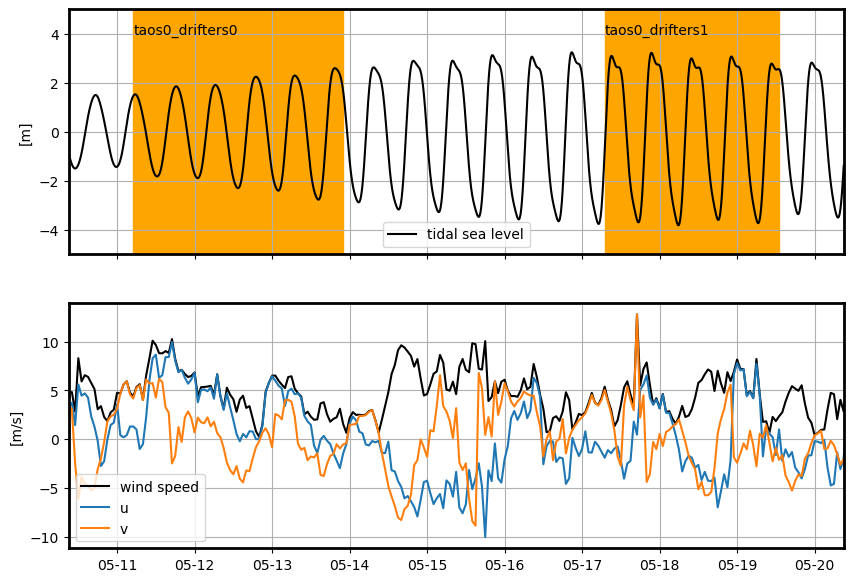

In [29]:
plot_combined_deployments(wind_stress=False)

### without sticks

In [26]:
def plot_combined_deployments(wind_stress=True):

    fig, axes = plt.subplots(2,1, figsize=(10,7))

    height=10
    y=0
    starts, ends = [], []

    ax = axes[0]

    for c, cp in C.items():

        start = mdates.date2num(cp["start"])
        end = mdates.date2num(cp["end"])
        rect = Rectangle((start, y-height/2.), end-start, height,
                         color="orange")
        ax.add_patch(rect)
        starts.append(start)
        ends.append(end)
        #print(start, end-start)
        ax.text(start, y+height*0.4, c)

    # sea level
    _mtime = Slvl[c].index.map(lambda t: mdates.date2num(t))
    #_slvl = Slvl[c].sea_level.values
    #ax.plot(_mtime, _slvl, color="k", label="sea level")
    _slvl = Slvl[c].sea_level_tide.values
    ax.plot(_mtime, _slvl, color="k", label="tidal sea level")

    delta_time = max(ends) - min(starts)

    def _set_axis(ax, xticklabels=True):

        ax.set_xlim(min(starts)-0.1*delta_time, max(ends)+0.1*delta_time)
        locator = mdates.AutoDateLocator(minticks=3)
        #formatter = mdates.AutoDateFormatter(locator)
        formatter = mdates.DateFormatter("%m-%d")
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        if not xticklabels:
            ax.set_xticklabels([])
        ax.grid()

    _set_axis(ax, xticklabels=False,)
    ax.legend()
    ax.set_ylabel("[m]")
    ax.set_ylim(-5,5)

    ### 
    ax = axes[1]

    # wind
    #for w in W:
    w = W[list(W)[1]]
    _mtime = mdates.date2num(w.time)
    lon, lat = cp["drifter0"]["d0"].start.lon, cp["drifter0"]["d0"].start.lat
    _w = w.sel(longitude=lon, latitude=lat, method="nearest")

    if wind_stress:
        # wind stress
        scale = -3600 # kg/m^3
        _uvstress = np.sqrt(_w.ustress**2+_w.vstress**2)
        ax.plot(_mtime, _uvstress/scale, color="k", label="wind stress")
        ax.plot(_mtime, _w.ustress/scale, label="u stress")
        ax.plot(_mtime, _w.vstress/scale, label="v stress")
        ax.set_ylabel("[Pa]")
    else:
        # wind speed
        _uv10 = np.sqrt(_w.u10m**2+_w.v10m**2)
        ax.plot(_mtime, _uv10, color="k", label="wind speed")
        ax.plot(_mtime, _w.u10m, label="u")
        ax.plot(_mtime, _w.v10m, label="v")
        ax.set_ylabel("[m/s]")

    _set_axis(ax)
    ax.legend()


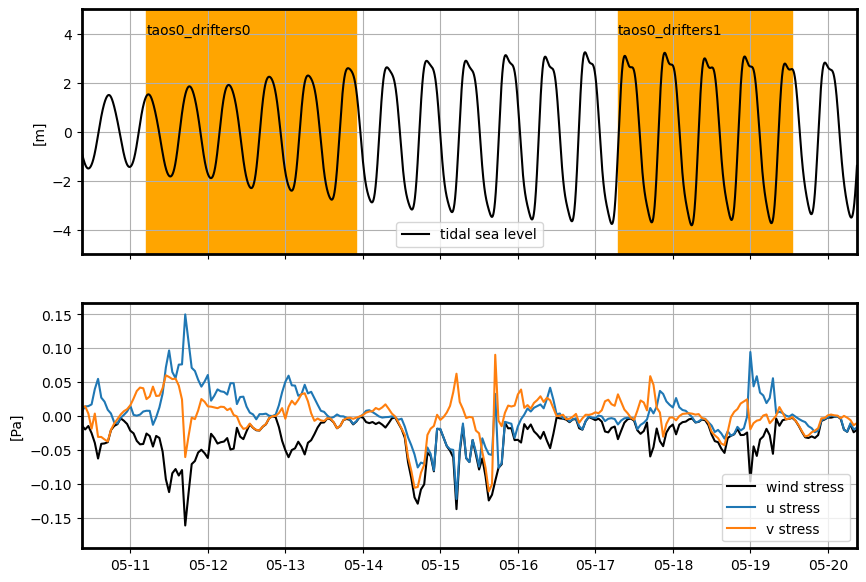

In [27]:
plot_combined_deployments(wind_stress=True)

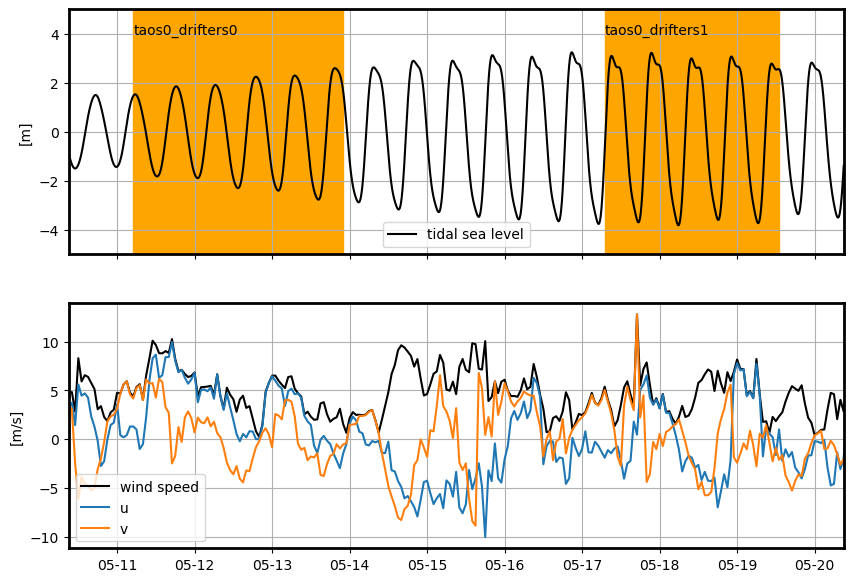

In [28]:
plot_combined_deployments(wind_stress=False)